# Homework 4

## Part a

In [1]:
import numpy as np
import pandas as pd

In [2]:
# load the data
df_train = pd.read_csv('Letters_train.csv')
df_test = pd.read_csv('Letters_test.csv')

# create a new variable called isB
df_train['isB'] = ['Yes' if x == 'B' else 'No' for x in df_train['letter']]
df_test['isB'] = ['Yes' if x == 'B' else 'No' for x in df_test['letter']]

df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2181 entries, 0 to 2180
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   letter     2181 non-null   object
 1   xbox       2181 non-null   int64 
 2   ybox       2181 non-null   int64 
 3   width      2181 non-null   int64 
 4   height     2181 non-null   int64 
 5   onpix      2181 non-null   int64 
 6   xbar       2181 non-null   int64 
 7   ybar       2181 non-null   int64 
 8   x2bar      2181 non-null   int64 
 9   y2bar      2181 non-null   int64 
 10  xybar      2181 non-null   int64 
 11  x2ybar     2181 non-null   int64 
 12  xy2bar     2181 non-null   int64 
 13  xedge      2181 non-null   int64 
 14  xedgeycor  2181 non-null   int64 
 15  yedge      2181 non-null   int64 
 16  yedgexcor  2181 non-null   int64 
 17  isB        2181 non-null   object
dtypes: int64(16), object(2)
memory usage: 306.8+ KB


### i)
The baseline model is to predict all "not B". So the accuracy of this baseline method on the test set is

In [3]:
np.sum(df_test['isB'] == 'No')/df_test.shape[0]

0.746524064171123

### ii)
Construct a logistic regression model to predict whether or not the letter is a B:

In [4]:
import statsmodels.formula.api as smf

# create a new numerical variable for isB
df_train['isBNum'] = [1 if x == 'Yes' else 0 for x in df_train['isB']]
df_test['isBNum'] = [1 if x == 'Yes' else 0 for x in df_test['isB']]

logreg = smf.logit(formula = 'isBNum ~ xbox + ybox + width + height + onpix + xbar + ybar + x2bar + \
                              y2bar + xybar + x2ybar + xy2bar + xedge + xedgeycor + yedge + yedgexcor',
                   data = df_train).fit()

print(logreg.summary())

Optimization terminated successfully.
         Current function value: 0.155134
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:                 isBNum   No. Observations:                 2181
Model:                          Logit   Df Residuals:                     2164
Method:                           MLE   Df Model:                           16
Date:                Tue, 26 Dec 2023   Pseudo R-squ.:                  0.7200
Time:                        16:23:57   Log-Likelihood:                -338.35
converged:                       True   LL-Null:                       -1208.3
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -13.5595      2.303     -5.888      0.000     -18.073      -9.046
xbox           0.0835      0

In [5]:
# predict the isBNum for test data using a threshold of p = 0.5
y_prob = logreg.predict(df_test)
y_pred = pd.Series([1 if x > 0.5 else 0 for x in y_prob], index=y_prob.index)

# create a confusion matrix
from sklearn.metrics import confusion_matrix
y_test = df_test['isBNum']
cm = confusion_matrix(y_test, y_pred)
print ("Confusion Matrix : \n", cm) 

Confusion Matrix : 
 [[667  31]
 [ 24 213]]


The accuracy of this logistic regression model is $$Accuracy = \frac{667+213}{667+31+24+213} = 0.9412$$

### iii)
Plot the ROC curve and calculate the AUC:

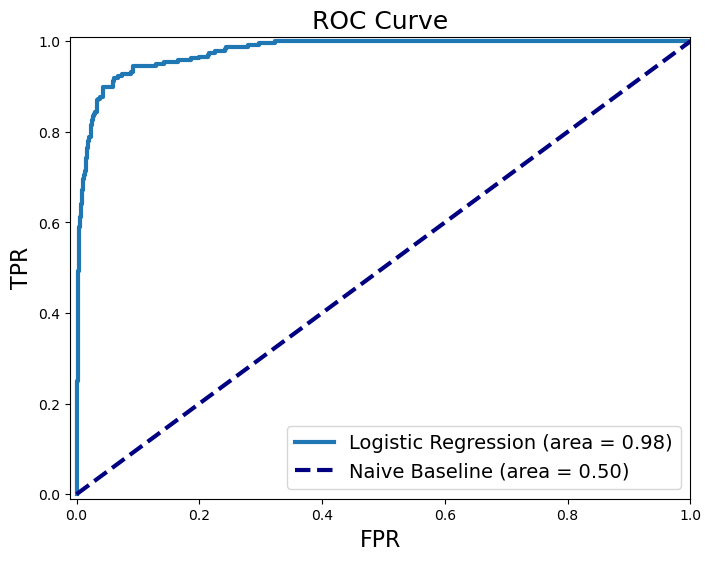

In [6]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr) #area under curve

plt.figure(figsize=(8, 6))
plt.title('ROC Curve', fontsize=18)
plt.xlabel('FPR', fontsize=16)
plt.ylabel('TPR', fontsize=16)
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr, tpr, lw=3, label='Logistic Regression (area = {:0.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--', label='Naive Baseline (area = 0.50)')
plt.legend(loc='lower right', fontsize=14)
plt.show()

AUC of this logistic regression model is 0.98.

### iv)
Construct a CART tree to predict whether or not a letter is a B:

In [7]:
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

In [8]:
# create the training data and testing data
X_train = df_train.drop(['letter', 'isB', 'isBNum'], axis=1)
y_train = df_train['isB']
X_test = df_test.drop(['letter', 'isB', 'isBNum'], axis=1)
y_test = df_test['isB']

In [9]:
# perform 5-fold cross validation
grid_values = {'ccp_alpha': np.linspace(0, 0.10, 201),
               'min_samples_leaf': [5],
               'min_samples_split': [20],
               'max_depth': [30],
               'class_weight' : [{'Yes': 1, 'No': 1}],
               'random_state': [88]}

dtc = DecisionTreeClassifier()

cv = KFold(n_splits=5, random_state=1, shuffle=True) 
dtc_cv_acc = GridSearchCV(dtc, param_grid = grid_values, scoring = 'accuracy', cv=cv, verbose=1) 
dtc_cv_acc.fit(X_train, y_train)

Fitting 5 folds for each of 201 candidates, totalling 1005 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
             estimator=DecisionTreeClassifier(),
             param_grid={'ccp_alpha': array([0.    , 0.0005, 0.001 , 0.0015, 0.002 , 0.0025, 0.003 , 0.0035,
       0.004 , 0.0045, 0.005 , 0.0055, 0.006 , 0.0065, 0.007 , 0.0075,
       0.008 , 0.0085, 0.009 , 0.0095, 0.01  , 0.0105, 0.011 , 0.0115,
       0.012 , 0.0125, 0.013 , 0.0135, 0.014 , 0.0145, 0.015 , 0.0155,
       0.016 , 0.0165, 0.017...
       0.084 , 0.0845, 0.085 , 0.0855, 0.086 , 0.0865, 0.087 , 0.0875,
       0.088 , 0.0885, 0.089 , 0.0895, 0.09  , 0.0905, 0.091 , 0.0915,
       0.092 , 0.0925, 0.093 , 0.0935, 0.094 , 0.0945, 0.095 , 0.0955,
       0.096 , 0.0965, 0.097 , 0.0975, 0.098 , 0.0985, 0.099 , 0.0995,
       0.1   ]),
                         'class_weight': [{'No': 1, 'Yes': 1}],
                         'max_depth': [30], 'min_samples_leaf': [5],
                         'min_samples_split': [20], 'random_state': [88]},
             scoring='accuracy', verbose=1)

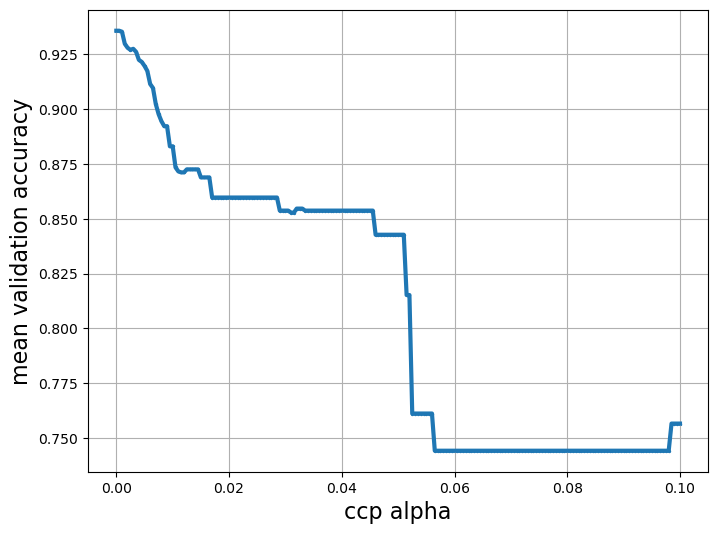

Grid best parameter ccp_alpha (max. accuracy):  0.0
Grid best score (accuracy):  0.9358134066718451


In [10]:
# select the optimal ccp_alpha value
acc = dtc_cv_acc.cv_results_['mean_test_score'] 
ccp = dtc_cv_acc.cv_results_['param_ccp_alpha'].data

plt.figure(figsize=(8, 6))
plt.xlabel('ccp alpha', fontsize=16)
plt.ylabel('mean validation accuracy', fontsize=16)
plt.scatter(ccp, acc, s=2)
plt.plot(ccp, acc, linewidth=3)
plt.grid(True, which='both')
plt.show()

print('Grid best parameter ccp_alpha (max. accuracy): ', dtc_cv_acc.best_params_['ccp_alpha'])
print('Grid best score (accuracy): ', dtc_cv_acc.best_score_)

To do the 5-fold cross validation, first divide the training data into 5 different groups. Leave one group of data as testing data, train the rest of data using CART model, and evaluate the mean validation accuracy on the testing data. Repeat the step above using different value of ccp. Select the ccp value that has highest accuracy. 

Node count = 107


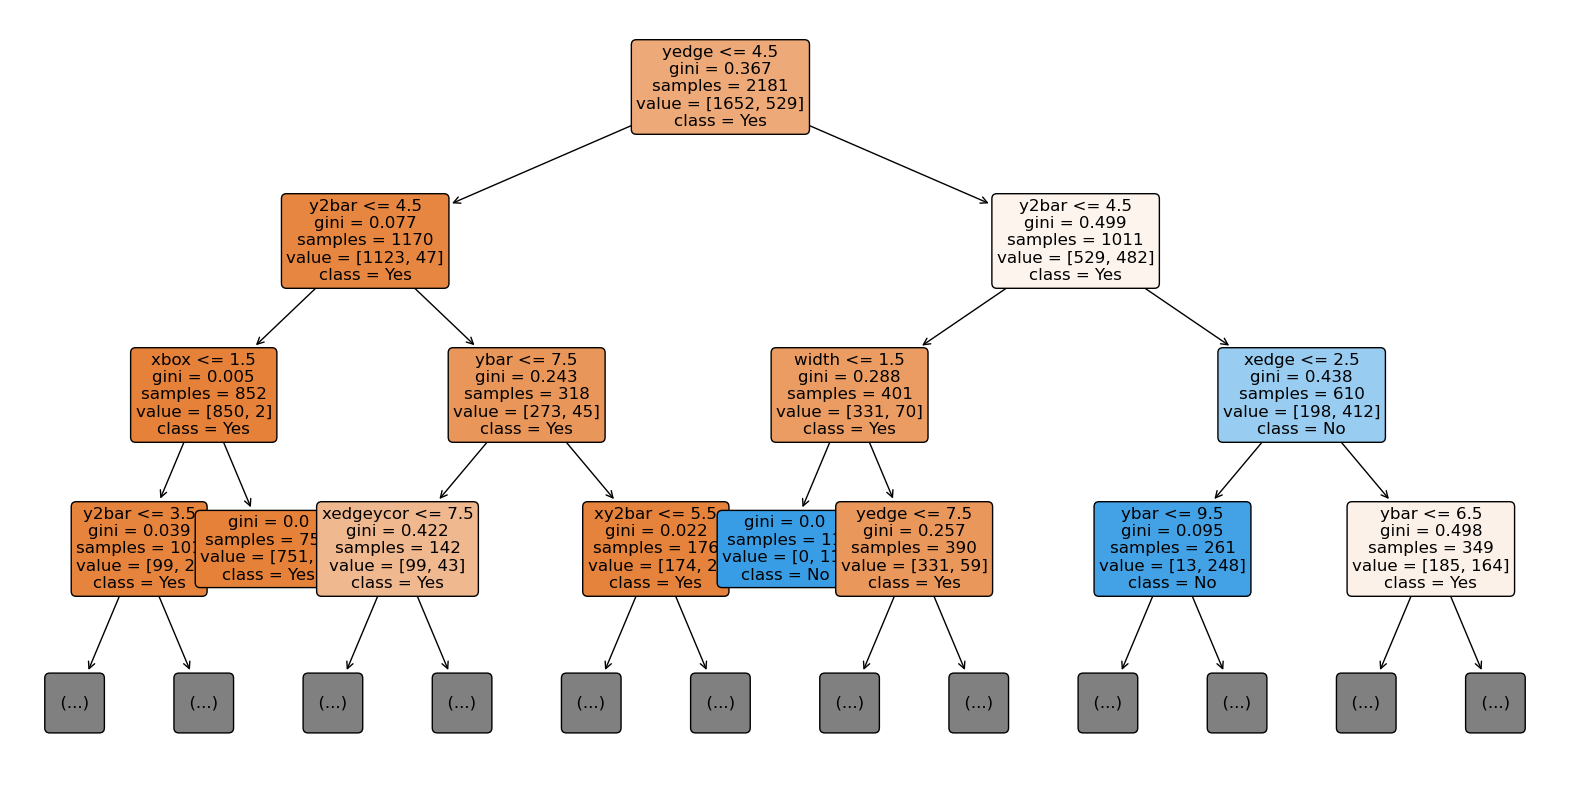

In [11]:
print('Node count =', dtc_cv_acc.best_estimator_.tree_.node_count)

plt.figure(figsize=(20,10))
plot_tree(dtc_cv_acc.best_estimator_, 
          feature_names=X_train.columns, 
          class_names=['Yes','No'],
          filled=True,
          impurity=True,
          rounded=True,
          fontsize=12,
          max_depth=3)
plt.show()

In [12]:
y_pred = dtc_cv_acc.best_estimator_.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

print("Confusion Matrix : \n", cm)

Confusion Matrix : 
 [[668  30]
 [ 31 206]]


The accuracy of this CART model is $$Accuracy = \frac{668+206}{668+30+31+206} = 0.9348$$

### v)
The accuracy of the logistic regression model is 0.9412, while the accuracy of the CART model is 0.9348. The logistic regression model performs best on the test set. For this application, I think the accuracy is more important than interpretability, because the it's still hard to interprete tha variables input using CART model since they are all attributes of the image in terms of pixels. On the other side, the accuracy of the logistic regression model is higher than the CART model and the AUC of the Logistic Regression model is 0.98, which means the logistic regression is more practical to predict whether is B or not. 

## Part b

### i)

In [13]:
# frequence of letter
df_test['letter'].value_counts()

letter
R    246
B    237
A    227
P    225
Name: count, dtype: int64

The most frequent letter over all of the letters in test data is R, so the baseline model is to predict R all the time. The baseline accuracy is $$Accuracy = \frac{246}{246+237+227+225} = 0.2631$$

### ii)
Construct a CART model to predict letter:

In [14]:
# create the training data and testing data
X_train = df_train.drop(['letter', 'isB', 'isBNum'], axis=1)
y_train = df_train['letter']
X_test = df_test.drop(['letter', 'isB', 'isBNum'], axis=1)
y_test = df_test['letter']

In [15]:
# set the CART parameter for cv
grid_values = {'ccp_alpha': np.linspace(0, 0.10, 201),
               'min_samples_leaf': [5],
               'min_samples_split': [20],
               'max_depth': [30],
               'class_weight' : [{'A': 1, 'B': 1, 'P': 1, 'R': 1}],
               'random_state': [88]}

dtc = DecisionTreeClassifier()

# use 5-fold cross validation 
cv = KFold(n_splits=5,random_state=1, shuffle=True) 
dtc_cv_acc = GridSearchCV(dtc, param_grid = grid_values, scoring = 'accuracy', cv=cv, verbose=1) 
dtc_cv_acc.fit(X_train, y_train)

Fitting 5 folds for each of 201 candidates, totalling 1005 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
             estimator=DecisionTreeClassifier(),
             param_grid={'ccp_alpha': array([0.    , 0.0005, 0.001 , 0.0015, 0.002 , 0.0025, 0.003 , 0.0035,
       0.004 , 0.0045, 0.005 , 0.0055, 0.006 , 0.0065, 0.007 , 0.0075,
       0.008 , 0.0085, 0.009 , 0.0095, 0.01  , 0.0105, 0.011 , 0.0115,
       0.012 , 0.0125, 0.013 , 0.0135, 0.014 , 0.0145, 0.015 , 0.0155,
       0.016 , 0.0165, 0.017...
       0.084 , 0.0845, 0.085 , 0.0855, 0.086 , 0.0865, 0.087 , 0.0875,
       0.088 , 0.0885, 0.089 , 0.0895, 0.09  , 0.0905, 0.091 , 0.0915,
       0.092 , 0.0925, 0.093 , 0.0935, 0.094 , 0.0945, 0.095 , 0.0955,
       0.096 , 0.0965, 0.097 , 0.0975, 0.098 , 0.0985, 0.099 , 0.0995,
       0.1   ]),
                         'class_weight': [{'A': 1, 'B': 1, 'P': 1, 'R': 1}],
                         'max_depth': [30], 'min_samples_leaf': [5],
                         'min_samples_split': [20], 'random_state': [88]},
             scoring='accuracy', verbose=1)

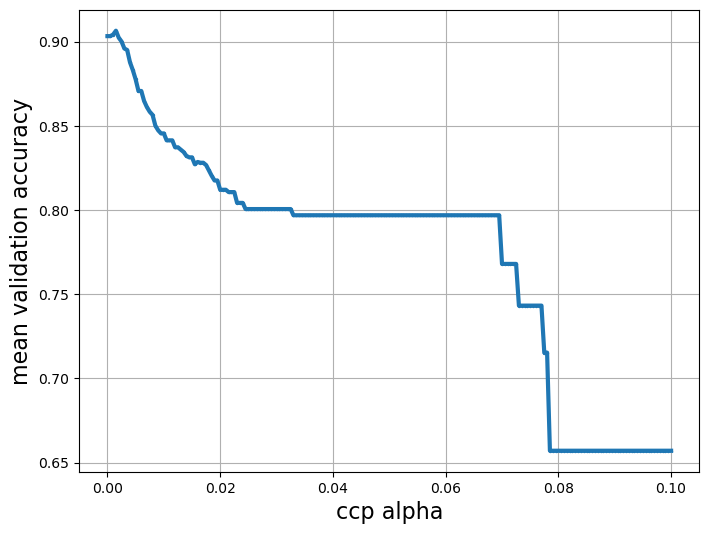

Grid best parameter ccp_alpha (max. accuracy):  0.0015
Grid best score (accuracy):  0.9064608569689081


In [16]:
# select the optimal ccp_alpha value
acc = dtc_cv_acc.cv_results_['mean_test_score'] 
ccp = dtc_cv_acc.cv_results_['param_ccp_alpha'].data

plt.figure(figsize=(8, 6))
plt.xlabel('ccp alpha', fontsize=16)
plt.ylabel('mean validation accuracy', fontsize=16)
plt.scatter(ccp, acc, s=2)
plt.plot(ccp, acc, linewidth=3)
plt.grid(True, which='both')
plt.show()

print('Grid best parameter ccp_alpha (max. accuracy): ', dtc_cv_acc.best_params_['ccp_alpha'])
print('Grid best score (accuracy): ', dtc_cv_acc.best_score_)

To do the 5-fold cross validation, first divide the training data into 5 different groups. Leave one group of data as testing data, train the rest of data using CART model, and evaluate the mean validation accuracy on the testing data. Repeat the step above using different value of ccp. Select the ccp value that has highest accuracy. 

Node count = 77


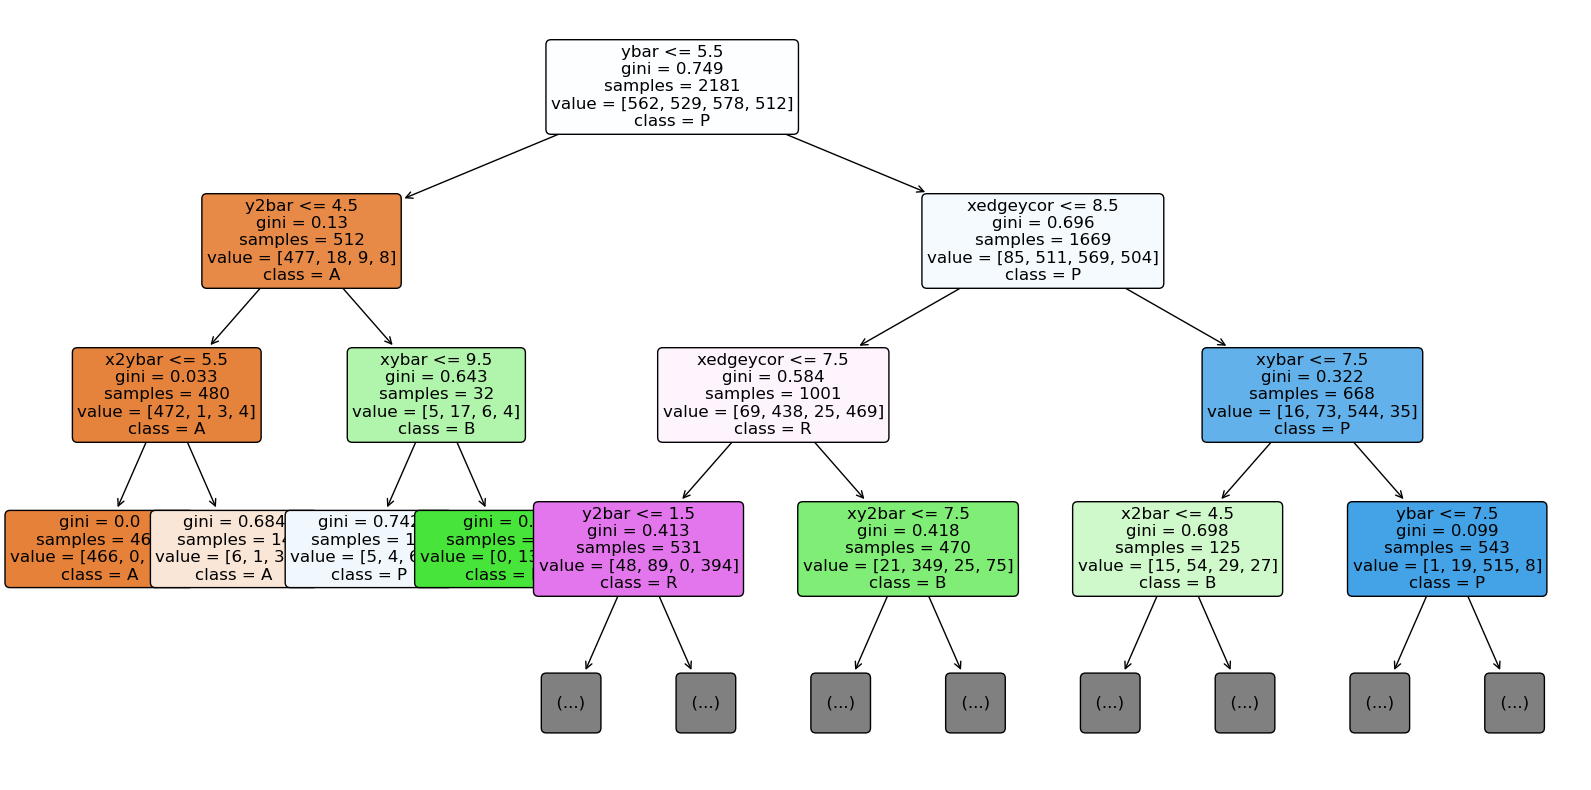

In [17]:
print('Node count =', dtc_cv_acc.best_estimator_.tree_.node_count)

plt.figure(figsize=(20,10))
plot_tree(dtc_cv_acc.best_estimator_, 
          feature_names=X_train.columns, 
          class_names=['A', 'B', 'P', 'R'],
          filled=True,
          impurity=True,
          rounded=True,
          fontsize=12,
          max_depth=3)
plt.show()

In [18]:
y_pred = dtc_cv_acc.best_estimator_.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

print("Confusion Matrix : \n", cm)

Confusion Matrix : 
 [[216   2   4   5]
 [  1 207  10  19]
 [  0   4 219   2]
 [  4  20   7 215]]


The accuracy of this CART model is $$Accuracy = \frac{216+207+219+215}{935} = 0.9166$$

### iii)
Construct a Random Forest (Classifier) model:

In [19]:
from sklearn.ensemble import RandomForestClassifier

In [20]:
# create the training data and testing data
X_train = df_train.drop(['letter', 'isB', 'isBNum'], axis=1)
y_train = df_train['letter']
X_test = df_test.drop(['letter', 'isB', 'isBNum'], axis=1)
y_test = df_test['letter']

In [21]:
# set the Random Forest parameter for cv
grid_values = {'max_features': np.linspace(1,16,16, dtype='int32'),
               'min_samples_leaf': [5],
               'n_estimators': [500],
               'random_state': [88]} 


rf = RandomForestClassifier() 

# use 5-fold cross validation 
cv = KFold(n_splits=5, random_state=333, shuffle=True) 
rf_cv = GridSearchCV(rf, param_grid=grid_values, scoring='accuracy', cv=cv,verbose=2)
rf_cv.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END max_features=1, min_samples_leaf=5, n_estimators=500, random_state=88; total time=   0.4s
[CV] END max_features=1, min_samples_leaf=5, n_estimators=500, random_state=88; total time=   0.4s
[CV] END max_features=1, min_samples_leaf=5, n_estimators=500, random_state=88; total time=   0.3s
[CV] END max_features=1, min_samples_leaf=5, n_estimators=500, random_state=88; total time=   0.3s
[CV] END max_features=1, min_samples_leaf=5, n_estimators=500, random_state=88; total time=   0.4s
[CV] END max_features=2, min_samples_leaf=5, n_estimators=500, random_state=88; total time=   0.4s
[CV] END max_features=2, min_samples_leaf=5, n_estimators=500, random_state=88; total time=   0.4s
[CV] END max_features=2, min_samples_leaf=5, n_estimators=500, random_state=88; total time=   0.4s
[CV] END max_features=2, min_samples_leaf=5, n_estimators=500, random_state=88; total time=   0.4s
[CV] END max_features=2, min_samples_leaf=5, n_e

GridSearchCV(cv=KFold(n_splits=5, random_state=333, shuffle=True),
             estimator=RandomForestClassifier(),
             param_grid={'max_features': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16],
      dtype=int32),
                         'min_samples_leaf': [5], 'n_estimators': [500],
                         'random_state': [88]},
             scoring='accuracy', verbose=2)

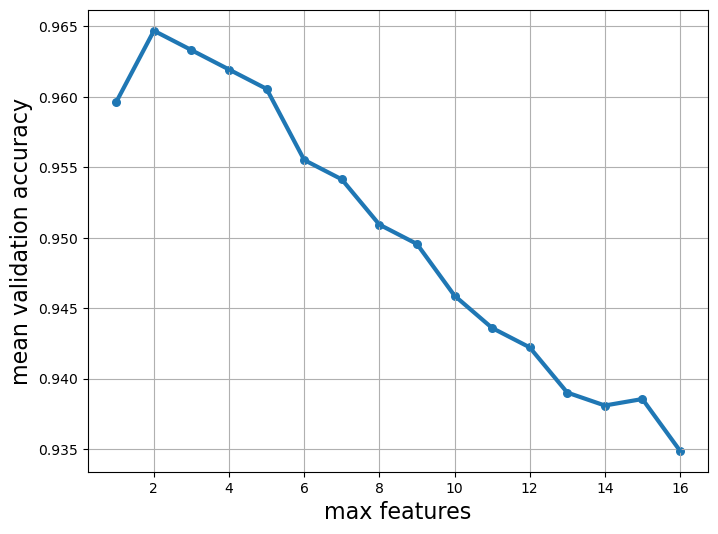

Grid best parameter max_features (max. accuracy):  2
Grid best score (accuracy):  0.9646967438540507


In [22]:
max_features = rf_cv.cv_results_['param_max_features'].data
acc = rf_cv.cv_results_['mean_test_score']

plt.figure(figsize=(8, 6))
plt.xlabel('max features', fontsize=16)
plt.ylabel('mean validation accuracy', fontsize=16)
plt.scatter(max_features, acc, s=30)
plt.plot(max_features, acc, linewidth=3)
plt.grid(True, which='both')
plt.show()

print('Grid best parameter max_features (max. accuracy): ', rf_cv.best_params_['max_features'])
print('Grid best score (accuracy): ', rf_cv.best_score_)

To do the 5-fold cross validation, first divide the training data into 5 different groups. Leave one group of data as testing data, train the rest of data using Random Forest model, and evaluate the mean validation accuracy on the testing data. Repeat the step above using different value of max_features. Select the max_features value that has highest accuracy. 

In [23]:
y_pred = rf_cv.best_estimator_.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

print("Confusion Matrix : \n", cm)

Confusion Matrix : 
 [[221   1   3   2]
 [  0 230   0   7]
 [  0   5 218   2]
 [  0  16   0 230]]


The accuracy of this Random Forest model is $$Accuracy = \frac{221+230+218+230}{935} = 0.9615$$

### iv)
The accuracy of the CART model is 0.9166, while the accuracy of the Random Forest model is 0.9615. So, I would recommend Random Forest model for this problem. Use bootstrapping to construct a confidence interval for its accuracy:

In [24]:
from sklearn.metrics import accuracy_score
from sklearn.utils import resample

# accurary on the original test set
y_pred = rf_cv.best_estimator_.predict(X_test)
acc_orginal = accuracy_score(y_test, y_pred)

# initialize an array to store the bootstrap sample accuracy scores
acc_boot = []

# bootstrap
for i in range(500):
    X_resampled, y_resampled = resample(X_test, y_test)
    y_pred = rf_cv.best_estimator_.predict(X_resampled)
    acc = accuracy_score(y_resampled, y_pred)
    acc_boot.append(acc)

# calcuate qL and qU
delta_acc = acc_boot - acc_orginal
ordered = sorted(delta_acc)
qL = np.percentile(ordered, 0.025)
qU = np.percentile(ordered, 0.975)

# compute CI
CI_lower = acc_orginal - qU
CI_upper = acc_orginal - qL
print("The 95% confidence interval of accuracy is ", (CI_lower, CI_upper)) 

The 95% confidence interval of accuracy is  (0.9764705882352942, 0.9826208556149734)
